In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ast
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import dynamic_extrusion_boundaries.util_visual as utvis
import cooler
import chromoscores.maputils as chrmap
import chromoscores.snipping as chrsnip
import chromoscores.scorefunctions as chrscores
import seaborn as sns

### Loading simulated data

In [2]:
path_dict = {}

directory = '../output/contact_maps/'

for name  in glob.glob(directory+'face_*'):
    path_dict[name.split('_maps/')[1][:].split('.mcool')[0]]= name
path_dict = dict(sorted(path_dict.items()))

In [3]:
exp_scores = pd.read_csv('../output/scores/experiments/experimental_data_table.csv')

# experimental values
Bonev_val_wt = exp_scores.query('measurement=="Isolation" and paper=="Bonev_2017" and condition=="WT"')['value']
Liu_val_wt = exp_scores.query('measurement=="Isolation" and paper=="Liu_2020" and condition=="WT"')['value']
Liu_val_wapl = exp_scores.query('measurement=="Isolation" and paper=="Liu_2020" and condition=="Wapl_6h"')['value']

In [4]:
### converting from lattice based 
TIME_CONV_COEF = 21.875 * 60 / 500 #to convert from lattice based to seconds
LATTICE_CONV_COEF = 0.25 #each lattice site is 0.25 kb

### investigating iso score

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log10
/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10


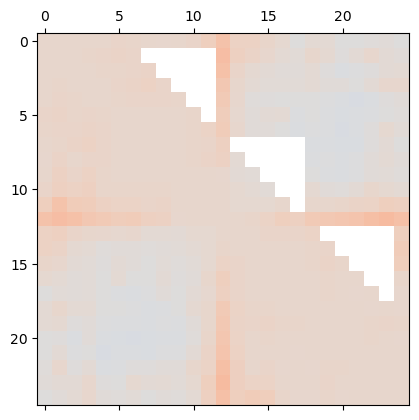

In [5]:
delta_val = 1
diag_offset_val = 5
max_distance_val = 20


#List of the position of boundary elements on the main diagonal. 
ctcfrightlist = [314, 579, 1195, 3717, 3772, 3921, 4451, 5193, 5723, 6302, 6574, 6779, 7000, 9232, 9310, 9861]
ctcfleftlist = [495, 865, 1404, 2164, 3143, 3615, 3971, 4069, 4480, 4938, 5300, 5587, 6401, 7725, 8764, 9619]
lst = np.sort((ctcfrightlist + ctcfleftlist))
lst = [int(lst[i]/(10*4) ) for i in range(len(lst))] # the 4 multiplier is for adjusting ctcf positions in 10 kb resolution
lst = np.array(lst)

### list of boundary elements on all replications
rep = 3 
mon = 1000//4
site = 10
lst_t = []
for i in range(rep):
    lst_t += list(np.array(lst)+i*mon)
lst_t = np.array(lst_t)

for name in list(path_dict.keys())[:1]:
    params = [ast.literal_eval(i) for i in name.split('_')[1::2]]
    face, back,clife, cof, life, slife, birth, pause, sep, site, mon, rep, step, vel = params
    cool_uri = (directory + '%s.mcool'%name)
    region = 'chr_sim:0-7500000' #region = 'chr_sim:0-7500000'
    cname = (cooler.Cooler(cool_uri+'.10000.cool').matrix(balance=False).fetch(region))
    mat=cname
    mrcn = mat
    mrc = mrcn.astype(float)
    mat = np.log10(mrc)
    mrc_exp=chrmap.get_observed_over_expected(mrc)
    pile=chrmap.get_diagonal_pileup(mrc_exp, lst_t[5:91],60)   #A function to pile up snippets around investigated features (here boundary elements)
    a,b,pile_c=chrscores._get_isolation_areas(pile,delta=delta_val,
                                              diag_offset=diag_offset_val,
                                              max_distance=max_distance_val,
                                              snippet_shapes='triangle')
    clr = cooler.Cooler(cool_uri+'.10000.cool')
    pseudocount = 0
    score = chrscores.isolation_score(pile,
                                    delta=delta_val,
                                    diag_offset=diag_offset_val,
                                    max_dist=max_distance_val,
                                    snippet_shapes='triangle',
                                    pseudo_count=pseudocount)
    for i in range(1):
        plt.matshow(np.log10(pile_c-(a+b)),vmin=0.9995,vmax=2.71,cmap='coolwarm')
    plt.show()

### Analysis

In [6]:
file = pd.read_csv('../output/scores/simulation/scores/isoscore_for_dynamic_random_pause_mod_1_5_30_traiangles_coolres10_s_points.csv')
file ['occupancy']=(file['clife']/(file['clife']+file['cof'])).round(2)

In [7]:
unique_life = np.unique(file['life'])
unique_vel = np.unique(file['velocity'])
unique_clife = np.unique(file['clife'])
unique_cof = np.unique(file['cof'])
unique_occup = np.unique(file['occupancy'])

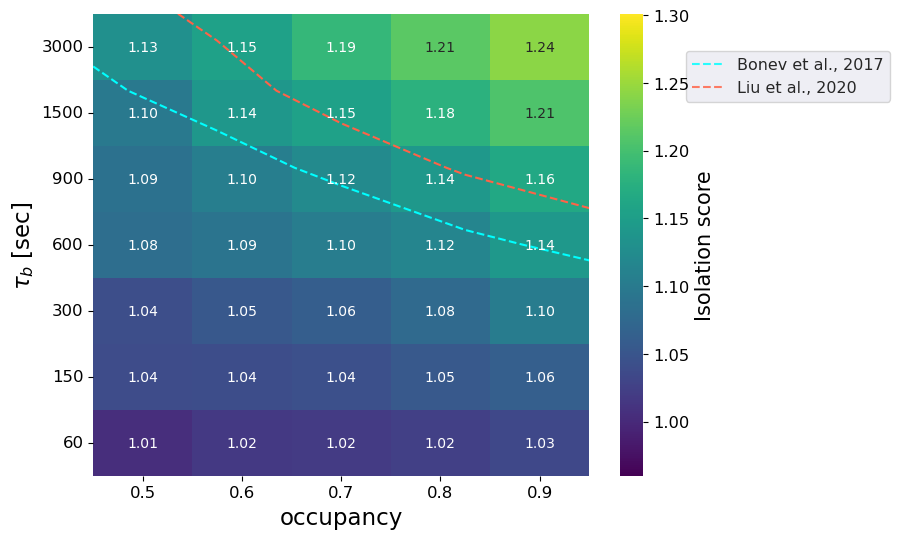

In [8]:
list_life, list_vel = [500], [1]

occupancy_range = [0.5, 0.6, 0.7, 0.8, 0.9]

for life in list(list_life):
    for vel in list(list_vel):
        new_file_filtered_unique = file.query('life==@life and velocity==@vel and occupancy in @occupancy_range')[['clife', 'occupancy', 'isoscore']]
        
        # Group by 'clife' and 'occupancy_bin', and calculate the mean of 'isoscore'
        dtaframe_grouped = new_file_filtered_unique.groupby(['clife', 'occupancy'], as_index=False).mean()
        dtaframe_grouped['clife'] = (dtaframe_grouped['clife'] * TIME_CONV_COEF).round()
        dtaframe_grouped = dtaframe_grouped.drop_duplicates(keep='first')
        dtaframe_grouped = dtaframe_grouped[dtaframe_grouped['clife'] > 30]
        dtaframe_grouped = dtaframe_grouped[dtaframe_grouped['clife'] <= 3000]
        heatmap_data = dtaframe_grouped.pivot('clife', 'occupancy', 'isoscore')
        
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f", vmin=0.96, vmax=1.301,
                         cbar_kws={'label': 'Frip score'})
        sns.set(font_scale=0.951)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11.75)
        cbar.set_label('Isolation score', fontsize=15)

        Bonev = utvis.make_equipotential_lines(heatmap_data,Bonev_val_wt, label = 'Bonev et al., 2017',
                                             num_line_x = 5, num_line_y = 7, color='cyan', linestyles='dashed')
        Liu = utvis.make_equipotential_lines(heatmap_data,Liu_val_wt,label='Liu et al., 2020',
                                             num_line_x = 5, num_line_y = 7, color='tomato', linestyles='dashed')


        # Format tick labels
        im.set_xticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_xticklabels()])
        im.set_yticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_yticklabels()])

        plt.xlabel('occupancy', fontsize=16.5)
        plt.xticks(fontsize=11.95, rotation=0)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize=16.5)
        plt.yticks(fontsize=11.95, rotation=0)
        # Add legend
        plt.legend(handles=[Bonev, Liu], loc=(1.195, 0.81), fontsize=11.5)
        plt.gca().invert_yaxis()
        plt.savefig('../output/figures/isosweep_for_occupancy_%s_%s.pdf'%(life, vel), transparent = True, bbox_inches = 'tight')
        plt.show()


### tau vs tau'

In [9]:
file = pd.read_csv('../output/scores/simulation/scores/isoscore_for_dynamic_random_pause_mod_1_5_30_traiangles_coolres10_tau_vs_taup.csv')

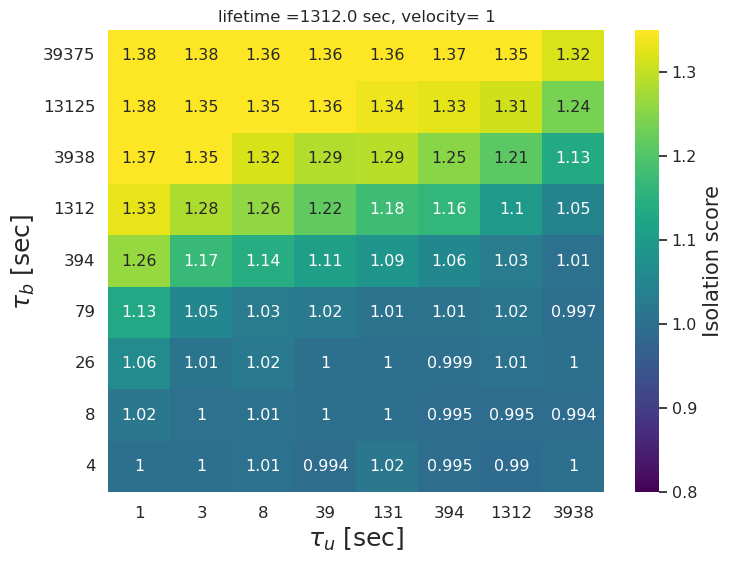

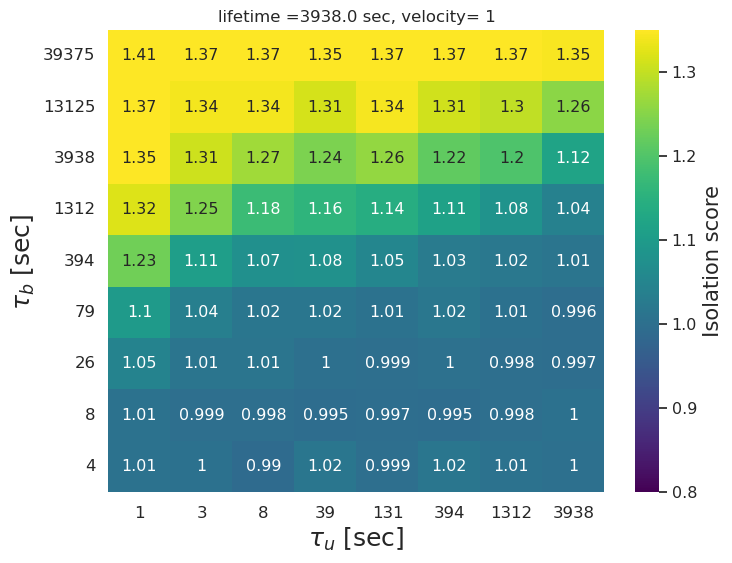

In [10]:
unique_life, unique_vel = [500.0, 1500.0], [1]

for life in list(unique_life):
    for vel in list(unique_vel):
        new_file = file.query('life==@life and velocity==@vel')[['clife','cof','isoscore']]
        new_file = new_file[new_file['cof']>0.15]
        new_file['clife']= np.round(TIME_CONV_COEF* new_file['clife'])
        new_file['cof']= np.round(TIME_CONV_COEF*new_file['cof'])
        heatmap_data = new_file.pivot('clife', 'cof', 'isoscore')
        
        # Create the heatmap using seaborn
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', vmax=1.35, vmin =0.8, fmt='.3g',cbar_kws={'label': 'Isolation score'} )
        sns.set(font_scale=0.951)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11.5)
        cbar.set_label('Isolation score', fontsize=15.15)

        # Customize labels and title
        im.set_xticklabels(['{:.1f}'.format(float(t.get_text())) for t in im.get_xticklabels()])
        plt.xlabel(r'$\tau_u$ [sec]', fontsize = 18)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize =18)
        plt.title('lifetime =%s sec, velocity= %s'%((np.round(life*TIME_CONV_COEF)), vel), fontsize = 11.95)
        plt.gca().invert_yaxis()
        im.set_xticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_xticklabels()])
        im.set_yticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_yticklabels()])
        plt.xticks(fontsize=11.95)
        plt.yticks(fontsize=11.95)
        plt.savefig('../output/figures/isolation_for_%s_%s_coolres10.pdf'%(life, vel), transparent = True, bbox_inches = 'tight')
        plt.show()

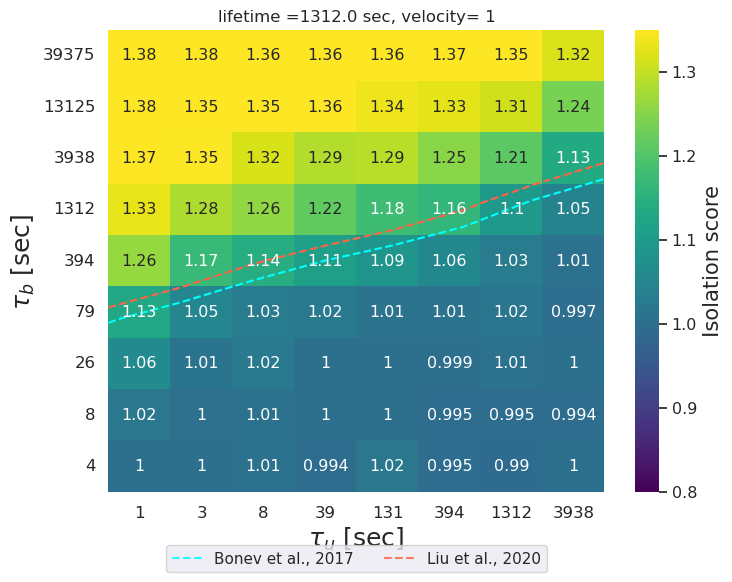

In [11]:
unique_life, unique_vel = [500.0], [1]
for life in list(unique_life):
    for vel in list(unique_vel):
        new_file = file.query('life==@life and velocity==@vel')[['clife','cof','isoscore']]
        new_file = new_file[new_file['cof']>0.15]
        new_file['clife']= np.round(TIME_CONV_COEF* new_file['clife'])
        new_file['cof']= np.round(TIME_CONV_COEF*new_file['cof'])
        heatmap_data = new_file.pivot('clife', 'cof', 'isoscore')
        
        # Create the heatmap using seaborn
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', vmax=1.35, vmin =0.8, fmt='.3g',cbar_kws={'label': 'Isolation score'} )
        sns.set(font_scale=0.951)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11.5)
        cbar.set_label('Isolation score', fontsize=15.15)

        Bonev = utvis.make_equipotential_lines(heatmap_data,Bonev_val_wt, label = 'Bonev et al., 2017',
                                             num_line_x = 8, num_line_y = 9, color='cyan', linestyles='dashed')
        Liu = utvis.make_equipotential_lines(heatmap_data,Liu_val_wt,label='Liu et al., 2020',
                                             num_line_x = 8, num_line_y = 9, color='tomato', linestyles='dashed')

        # Customize labels and title
        im.set_xticklabels(['{:.1f}'.format(float(t.get_text())) for t in im.get_xticklabels()])
        plt.xlabel(r'$\tau_u$ [sec]', fontsize = 18)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize =18)
        plt.title('lifetime =%s sec, velocity= %s'%((np.round(life*TIME_CONV_COEF)), vel), fontsize = 11.95)
        plt.gca().invert_yaxis()
        im.set_xticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_xticklabels()])
        im.set_yticklabels([int(float(t.get_text())) if float(t.get_text()).is_integer() else t.get_text() for t in im.get_yticklabels()])
        plt.xticks(fontsize=11.95)
        plt.yticks(fontsize=11.95)
        # Add legend
        plt.legend(handles=[Bonev, Liu], loc='upper center', bbox_to_anchor=(0.5, -0.0986), fontsize=10.95, ncol = 2)
        plt.savefig('../output/figures/isolation_for_%s_%s_coolres10_estimate_exp.pdf'%(life, vel), transparent = True, bbox_inches = 'tight')
        plt.show()


### iso wt vs iso wapl

In [23]:
iso = pd.read_csv('../output/scores/simulation/scores/isoscore_for_dynamic_random_pause_mod_1_5_30_traiangles_coolres10_s_points.csv')


In [24]:
iso['occup']= (iso['clife']/(iso['clife']+iso['cof'])).round(2)

In [25]:
iso_wt, iso_wapl  = iso[iso['life']==500], iso[iso['life']==1500]

In [26]:
common_columns = [ 'velocity', 'clife', 'cof', 'occup']

# Merge the datasets on the common columns
iso_wt_70 = iso_wt[iso_wt['occup']==0.70]
iso_wapl_70 = iso_wapl[iso_wapl['occup']==0.70]
merged_df = pd.merge(iso_wt_70, iso_wapl_70, on=common_columns, how='inner')
merged_df ['clife'] = (merged_df['clife']*TIME_CONV_COEF).round()
merged_df

,life_x,velocity,clife,cof,isoscore_x,occup,life_y,isoscore_y
0,500.0,1,300.0,48.98,1.060682,0.7,1500.0,1.047369
1,500.0,1,3000.0,489.80,1.187553,0.7,1500.0,1.154109
2,500.0,1,30000.0,4897.96,1.234193,0.7,1500.0,1.243910
3,500.0,1,60.0,9.80,1.019844,0.7,1500.0,1.005287
4,500.0,1,600.0,97.96,1.103858,0.7,1500.0,1.063189
5,500.0,1,6000.0,979.59,1.202430,0.7,1500.0,1.195808
6,500.0,1,900.0,146.94,1.121515,0.7,1500.0,1.088317
7,500.0,1,9000.0,1469.39,1.210818,0.7,1500.0,1.188293
8,500.0,1,150.0,24.49,1.042979,0.7,1500.0,1.030979
9,500.0,1,1500.0,244.90,1.154012,0.7,1500.0,1.107544


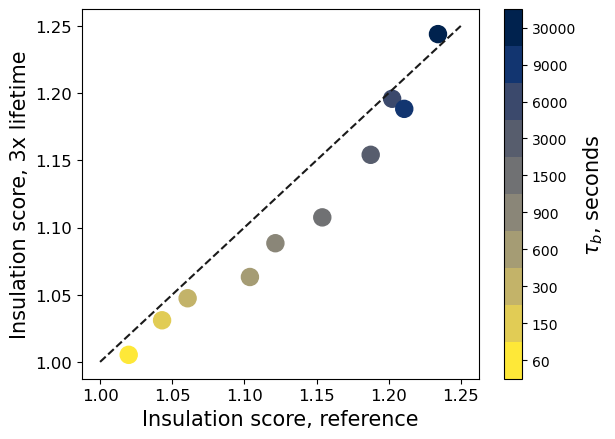

In [27]:
sns.reset_defaults()

# sort the DataFrame based on 'clife'
merged_df = merged_df.sort_values(by=['clife'])

# Number of unique points (colors) you want
num_colors = len(merged_df['clife'].unique())
cmap = plt.cm.get_cmap('cividis_r', num_colors)
norm = mcolors.BoundaryNorm(boundaries=np.arange(-0.5, num_colors), ncolors=num_colors)

clife_indices = merged_df['clife'].rank(method='dense').astype(int) - 1

# Create a scatter plot using discrete colors
sc = plt.scatter(
    merged_df['isoscore_x'], 
    merged_df['isoscore_y'],
    s = 150, 
    c = clife_indices,  # Use mapped indices for coloring
    cmap = cmap,
    norm = norm  # Use the defined norm for correct color mapping
)

# Add a plot line
plt.plot([1, 1.25], [1, 1.25], '--k')
plt.xlabel('Insulation score, reference', fontsize=15)
plt.ylabel('Insulation score, 3x lifetime', fontsize=15)
cbar = plt.colorbar(sc, ticks=np.arange(num_colors))
cbar.set_label(r'$\tau_b$, seconds', fontsize=15)
cbar.ax.set_yticklabels([f'{clife:.2f}' for clife in sorted(merged_df['clife'].unique())])
cbar.ax.set_yticklabels([f'{int(clife)}' for clife in sorted(merged_df['clife'].unique())])
plt.xticks(fontsize=11.95)
plt.yticks(fontsize=11.95)
plt.savefig('../output/figures/isowt_vs_isowapl.pdf', transparent=True, dpi=500)
plt.show()


In [19]:
iso = pd.read_csv('../output/scores/simulation/scores/isoscore_for_dynamic_random_pause_mod_1_5_30_traiangles_coolres10_s_points.csv')
iso['occup']= (iso['clife']/(iso['clife']+iso['cof'])).round(2)
iso_wt, iso_wapl  = iso[iso['life']==500], iso[iso['life']==1500]
iso_wt
common_columns = [ 'velocity', 'clife', 'cof', 'occup']

# Merge the datasets on the common columns
iso_wt_70 = iso_wt[iso_wt['occup']==0.70]
iso_wapl_70 = iso_wapl[iso_wapl['occup']==0.70]

merged_df = pd.merge(iso_wt_70, iso_wapl_70, on=common_columns, how='inner')

merged_df ['clife'] = (merged_df['clife'])
merged_df
clife_list = [22.86, 342.86, 571.43, 11428.57]

merged_df_sort = merged_df[merged_df['clife'].isin(clife_list)]
merged_df_sort = merged_df_sort.sort_values('clife')
merged_df_sort

,life_x,velocity,clife,cof,isoscore_x,occup,life_y,isoscore_y
3,500.0,1,22.86,9.80,1.019844,0.7,1500.0,1.005287
6,500.0,1,342.86,146.94,1.121515,0.7,1500.0,1.088317
9,500.0,1,571.43,244.90,1.154012,0.7,1500.0,1.107544
2,500.0,1,11428.57,4897.96,1.234193,0.7,1500.0,1.243910


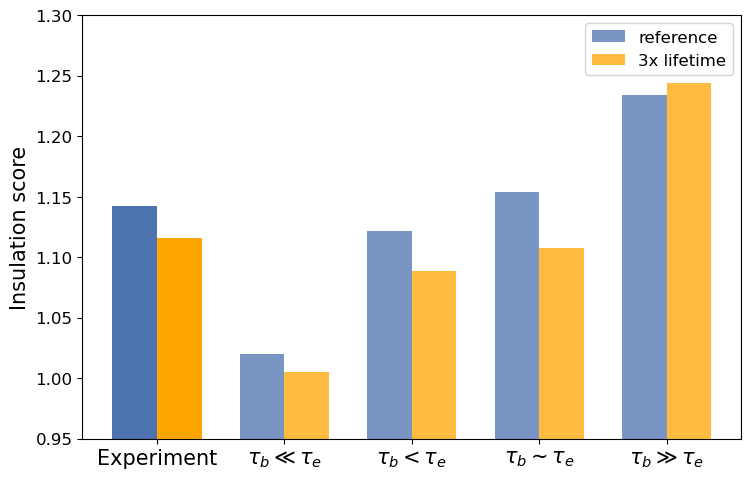

In [22]:
# Define tau_e for comparison
tau_e = 500

# Add a new column for labels based on conditions
def get_label(clife, tau_e):
    if clife < 0.1 * tau_e:
        return r'$\tau_b \ll \tau_e$'
    elif 0.1 * tau_e < clife < tau_e:
        return r'$\tau_b < \tau_e$'
    elif clife > 1.5 * tau_e:
        return r'$\tau_b \gg \tau_e$'
    else:
        return r'$\tau_b \sim \tau_e$'

merged_df_sort['label'] = merged_df_sort['clife'].apply(lambda x: get_label(x, tau_e))

fig, ax = plt.subplots(figsize=(8.5, 5.5))
bar_width = 0.35
exp_index = 0  # Positioning them at the beginning of the plot
bars3 = ax.bar(exp_index, Liu_val_wt, bar_width, color = 'b')
bars4 = ax.bar(exp_index + bar_width, Liu_val_wapl, bar_width, color = 'orange')

# Create positions for bars and plot for merged_df_sort
index = np.arange(1, len(merged_df_sort) + 1)  # Start from 1 for the subsequent data
bars1 = ax.bar(index, merged_df_sort['isoscore_x'], bar_width, label='reference', color='b', alpha = 0.75)
bars2 = ax.bar(index + bar_width, merged_df_sort['isoscore_y'], bar_width, label='3x lifetime', color='orange', alpha = 0.75)

# Set labels and title
ax.set_ylabel('Insulation score', fontsize=15)
ax.set_xticks(np.append(exp_index + bar_width / 2, index + bar_width / 2))
ax.set_xticklabels(['Experiment'] + list(merged_df_sort['label']), fontsize = 15)
ax.set_ylim(0.95, 1.3)
ax.tick_params(axis='y', labelsize=12) 

# Add a legend
ax.legend(fontsize = 11.95)
plt.savefig('../output/figures/bar_for_isolation.pdf', transparent = True)
plt.show()
